In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, warnings

from astropy.coordinates import SkyCoord
from astropy import units as u

sys.path.append(os.path.expanduser("~")+'/git/Python/user_modules/')
import match_coord

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
wisecat = Table.read('/Users/roz18/Documents/Data/desi_lrg_selection/wisemask/w1_bright-13.3_trim_dr5_region.fits')
print(len(wisecat))
twomass = Table.read('/Users/roz18/Documents/Data/desi_lrg_selection/wisemask/2mass_psc.fits')
print(len(twomass))

10818724
1263916


In [4]:
twomass.remove_columns(['_RAJ2000', '_DEJ2000'])
twomass.rename_column('RAJ2000', 'RA')
twomass.rename_column('DEJ2000', 'DEC')

print(wisecat.colnames)
print(twomass.colnames)

['RA', 'DEC', 'W1MPRO']
['RA', 'DEC', 'Jmag', 'Hmag', 'Kmag']


In [14]:
# Convert to the ecliptic coordinates
c_wise = SkyCoord(ra=wisecat['RA']*u.degree, dec=wisecat['DEC']*u.degree, frame='icrs')
c_twomass = SkyCoord(ra=twomass['RA'], dec=twomass['DEC'], frame='icrs')

temp = c_wise.galactic
wise_b, wise_l = np.array(temp.b), np.array(temp.l)
temp = c_twomass.galactic
twomass_b, twomass_l = np.array(temp.b), np.array(temp.l)

In [15]:
print(wisecat['DEC'].min())
print(wisecat['DEC'].max())
print(np.abs(wise_b).min())

-20.9999971
35.9999946
9.999994909882076


__Require -20$<$DEC$<$35 AND |b|$>$15__

In [16]:
mask = (twomass['DEC']>-20.) & (twomass['DEC']<35.) & (np.abs(twomass_b)>15.)
twomass = twomass[mask]
print(len(twomass)/len(mask))
print(twomass['DEC'].min())
print(twomass['DEC'].max())
print(np.abs(twomass_b[mask]).min())

mask = (wisecat['DEC']>-20.) & (wisecat['DEC']<35.) & (np.abs(wise_b)>15.)
wisecat = wisecat[mask]
print(len(wisecat)/len(mask))
print(np.abs(wise_b[mask]).min())

0.4814196513059412
-19.999971
34.999588
15.000064475775066
0.7218924338951618
15.000000859964125


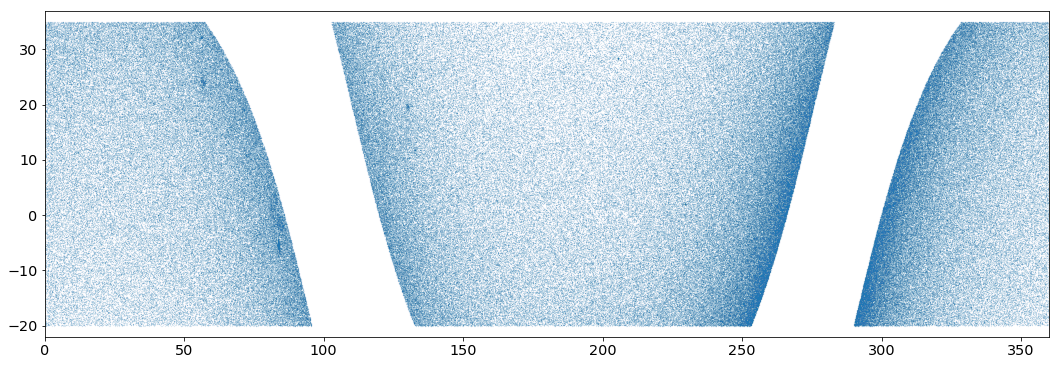

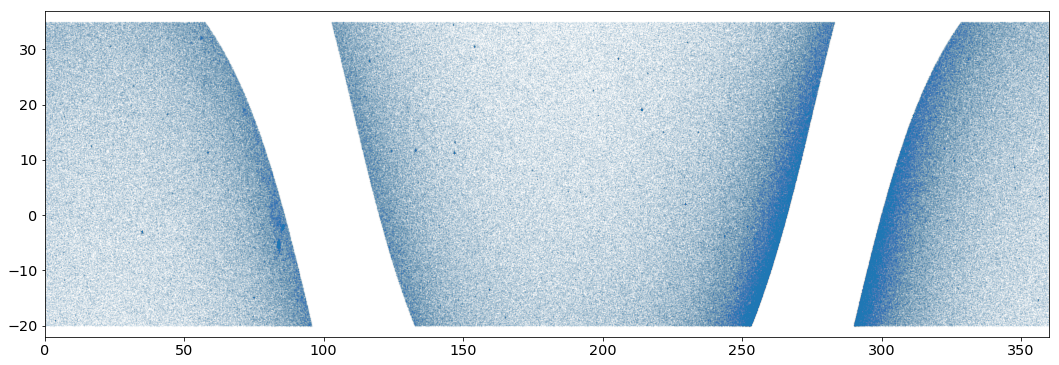

In [17]:
plt.figure(figsize=(18, 6))
plt.plot(twomass['RA'], twomass['DEC'], '.', markersize=0.2, alpha=0.5)
plt.axis([0, 360, -22, 37])
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(wisecat['RA'][::5], wisecat['DEC'][::5], '.', markersize=0.2, alpha=0.2)
plt.axis([0, 360, -22, 37])
plt.show()

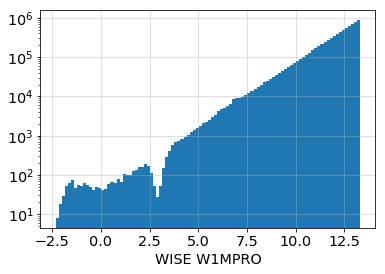

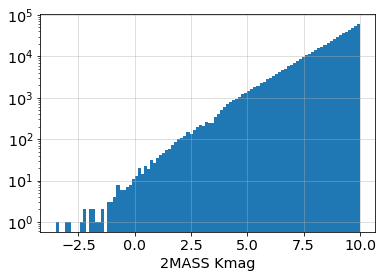

In [21]:
plt.hist(wisecat['W1MPRO'], 100, log=True)
plt.xlabel('WISE W1MPRO')
plt.grid(alpha=0.5)
plt.show()

plt.hist(twomass['Kmag'], 100, log=True)
plt.xlabel('2MASS Kmag')
plt.grid(alpha=0.5)
plt.show()

Doubly matched objects = 1672
Final matched objects = 594622


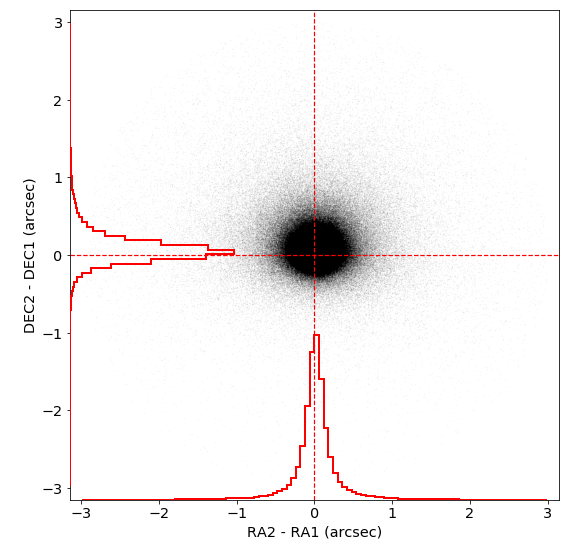

In [11]:
idx1, idx2, _, _, _ = match_coord.match_coord(wisecat['RA'], wisecat['DEC'], twomass['RA'], twomass['DEC'], search_radius=3.)

In [13]:
print('{:.2f}% 2MASS sources are matched to AllWISE'.format(len(idx2)/len(twomass)*100))
w1max = 8
print('{:.2f}% AllWISE sources with W1<8 are matched to 2MASS'.format(np.sum(wisecat['W1MPRO'][idx1]<w1max)/np.sum(wisecat['W1MPRO']<w1max)*100))

97.72% 2MASS sources are matched to AllWISE
97.51% AllWISE sources with W1<8 are matched to 2MASS


In [14]:
# plt.hist(wisecat['W1MPRO'][idx1], 100, log=True)
# plt.show()

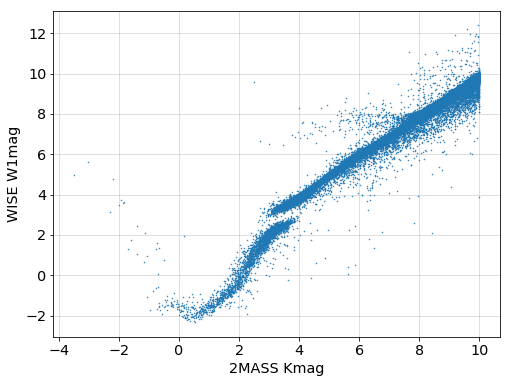

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(twomass['Kmag'][idx2], wisecat['W1MPRO'][idx1], '.', markersize=1)
plt.xlabel('2MASS Kmag')
plt.ylabel('WISE W1MPRO')
plt.grid(alpha=0.5)
plt.show()

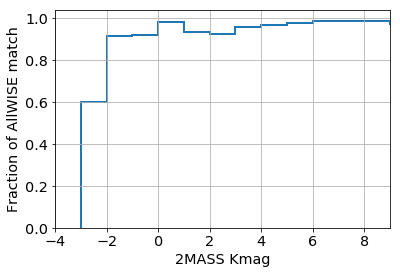

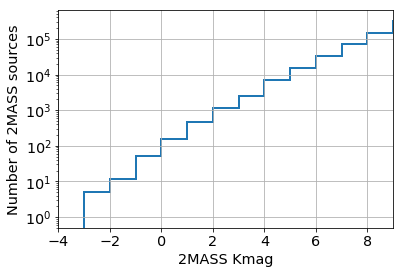

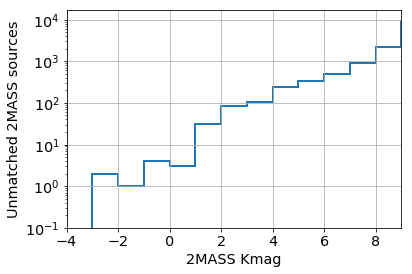

In [16]:
tm_match = np.zeros(len(twomass), dtype=bool)
tm_match[idx2] = True

bins = np.linspace(-3, 10, 14)
bin_center = (bins[1:]+bins[:-1])/2
hist_match = np.histogram(twomass['Kmag'][tm_match], bins=bins)[0]
hist_all = np.histogram(twomass['Kmag'], bins=bins)[0]
frac = hist_match/hist_all

plt.hist(bin_center, bins=bins, weights=frac, histtype='step', lw=2)
plt.xlabel('2MASS Kmag')
plt.ylabel('Fraction of AllWISE match')
plt.xlim(-4, 9)
plt.grid()
plt.show()

plt.hist(bin_center, bins=bins, weights=hist_all, histtype='step', lw=2, log=True)
plt.xlabel('2MASS Kmag')
plt.ylabel('Number of 2MASS sources')
plt.xlim(-4, 9)
plt.grid()
plt.show()

plt.hist(bin_center, bins=bins, weights=(hist_all-hist_match), histtype='step', lw=2, log=True)
plt.xlabel('2MASS Kmag')
plt.ylabel('Unmatched 2MASS sources')
plt.xlim(-4, 9)
plt.grid()
plt.show()

In [18]:
print('{} ({:.2f}%) 2MASS sources with Kmag<2 are missing from AllWISE'
      .format(np.sum(twomass['Kmag'][~tm_match]<=2), 100*np.sum(twomass['Kmag'][~tm_match]<=2)/np.sum(twomass['Kmag']<=2)))

41 (6.00%) 2MASS sources with Kmag<2 are missing from AllWISE


2MASS source missing in AllWISE


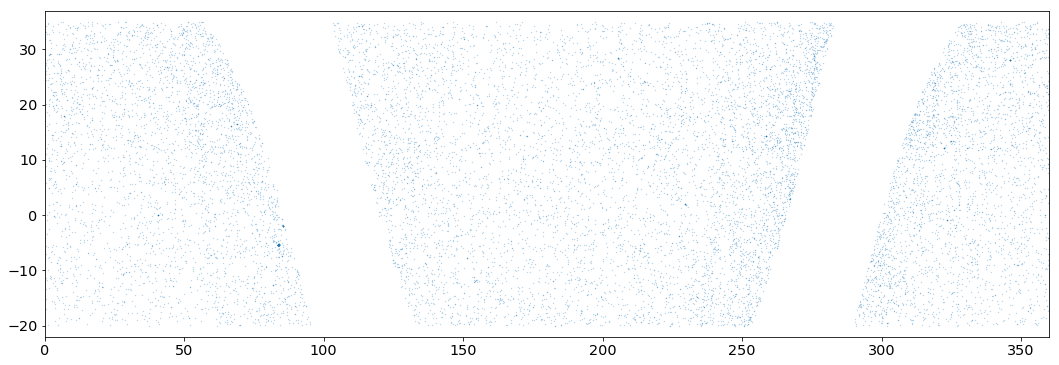

In [23]:
print('2MASS source missing in AllWISE')
plt.figure(figsize=(18, 6))
plt.plot(twomass['RA'][~tm_match], twomass['DEC'][~tm_match], '.', markersize=0.5, alpha=0.5)
plt.axis([0, 360, -22, 37])
plt.show()

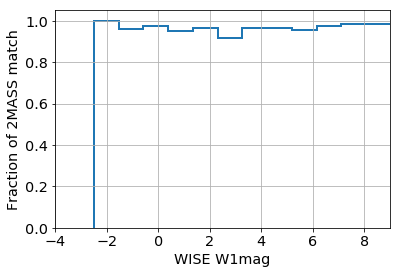

In [22]:
wise_match = np.zeros(len(wisecat), dtype=bool)
wise_match[idx1] = True

bins = np.linspace(-2.5, 10, 14)
bin_center = (bins[1:]+bins[:-1])/2
hist_match = np.histogram(wisecat['W1MPRO'][wise_match], bins=bins)[0]
hist_all = np.histogram(wisecat['W1MPRO'], bins=bins)[0]
frac = hist_match/hist_all

plt.hist(bin_center, bins=bins, weights=frac, histtype='step', lw=2)
plt.xlabel('WISE W1MPRO')
plt.ylabel('Fraction of 2MASS match')
plt.xlim(-4, 9)
plt.grid()
plt.show()

# plt.hist(bin_center, bins=bins, weights=hist_all, histtype='step', lw=2, log=True)
# plt.xlabel('WISE W1MPRO')
# plt.ylabel('Number of AllWISE sources')
# plt.xlim(-4, 9)
# plt.grid()
# plt.show()

In [21]:
# match_indices = np.array([idx1, idx2])
# np.save('/Users/roz18/Downloads/2mass_psc-Allwise.npy', match_indices)

# # idx1, idx2 = np.load('/Users/roz18/Downloads/2mass_psc-Allwise.npy')

__Examine missing 2MASS sources in viewer__

In [39]:
# t = twomass[~tm_match]
# mask = t['Kmag']<4
# print(np.sum(mask))
# t = t[mask]
# t.write('/Users/roz18/Downloads/missing_2mass_sources.fits')

317


In [41]:
# t = twomass[~tm_match]
# mask = t['Kmag']<0
# print(np.sum(mask))
# t = t[mask]
# t.write('/Users/roz18/Downloads/missing_2mass_sources_2.fits')

14


In [43]:
# t = twomass
# mask = t['Kmag']<4
# print(np.sum(mask))
# t = t[mask]
# t.write('/Users/roz18/Downloads/missing_2mass_sources_3.fits')

4390
